# DPU example: Resnetv1 using Vitis AI Runtime (VART)

This notebooks shows an example of DPU applications. The application,
as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
For more information, please refer to the 
[Xilinx Vitis AI page](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

In this notebook, we will show how to use **VART** to run DPU tasks.

## 1. Prepare the overlay
We will download the overlay onto the board. 

By default, `DpuOverlay` object will set the DPU runtime to be `dnndk`;
in this example, we will change it to `vart`. You cannot use them both at the
same time because of memory allocation conflicts - users need to choose either one.

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.set_runtime("vart")
overlay.load_model("dpu_tf_resnetv1_0.elf")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [2]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Let's first define a few useful preprocessing functions. These functions
will make sure the DPU can take input images with arbitrary sizes.

In [3]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image, crop_height = 224, crop_width = 224):
    image = resize_shortest_edge(image, 256)
    image = mean_image_subtraction(image, MEANS)
    image = central_crop(image, crop_height, crop_width)
    return image

We will also define a few functions to calculate softmax and provide 
the output class after running a DPU task.

In [4]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

def predict_label(softmax):
    with open("img/words.txt", "r") as f:
        lines = f.readlines()
    return lines[np.argmax(softmax)-1]

Keep in mind that our original images are 640x480 so we need to preprocess them
later to make sure it fits our model.

In [5]:
image_folder = 'img'
original_images = [i for i in os.listdir(image_folder) if i.endswith("JPEG")]
total_images = len(original_images)

## 3. Use VART
Now we should be able to use VART to do image classification.

In [6]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

outputHeight = outputTensors[0].dims[1]
outputWidth = outputTensors[0].dims[2]
outputChannel = outputTensors[0].dims[3]
outputSize = outputHeight*outputWidth*outputChannel
softmax = np.empty(outputSize)

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

In [7]:
shape_in = (1,) + tuple(
    [inputTensors[0].dims[i] for i in range(inputTensors[0].ndim)][1:])
shape_out = (1, outputHeight, outputWidth, outputChannel)
input_data = []
output_data = []
input_data.append(np.empty((shape_in), 
                            dtype = np.float32, order = 'C'))
output_data.append(np.empty((shape_out), 
                            dtype = np.float32, order = 'C'))
image = input_data[0]

Remember that we have a list of `original_images`. 
We can now define a new function `run()` which takes the image index as 
the input, and calculate the softmax as the classification result.
With the argument `display` set to `True`, the original image as well as the
predicted label can be rendered.

It is obvious that the range of `image_index` should be [0, `total_images`-1].

In [8]:
def run(image_index, display=False):
    preprocessed = preprocess_fn(cv2.imread(
        os.path.join(image_folder, original_images[image_index])))
    image[0,...] = preprocessed.reshape(
        inputTensors[0].dims[1],
        inputTensors[0].dims[2],
        inputTensors[0].dims[3])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    if display:
        display_image = cv2.imread(os.path.join(
            image_folder, original_images[image_index]))
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
        print("Classification: {}".format(predict_label(softmax)))

Let's run it for 1 image and print out the predicted label.

Classification: Arctic fox, white fox, Alopex lagopus



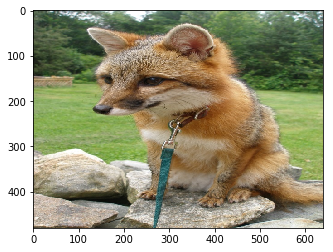

In [9]:
run(1, display=True)

We can also run it for multiple images as shown below. In this example
we have only used 1 thread; in principle, users should be able to boost
the performance by employing more threads.

In [10]:
time1 = time.time()
[run(i) for i in range(total_images)]
time2 = time.time()
fps = total_images/(time2-time1)
print("Performance: {} FPS".format(fps))

Performance: 24.917890984702215 FPS


Copyright (C) 2020 Xilinx, Inc